#### Architecture - Semantic Search using Elastic Search


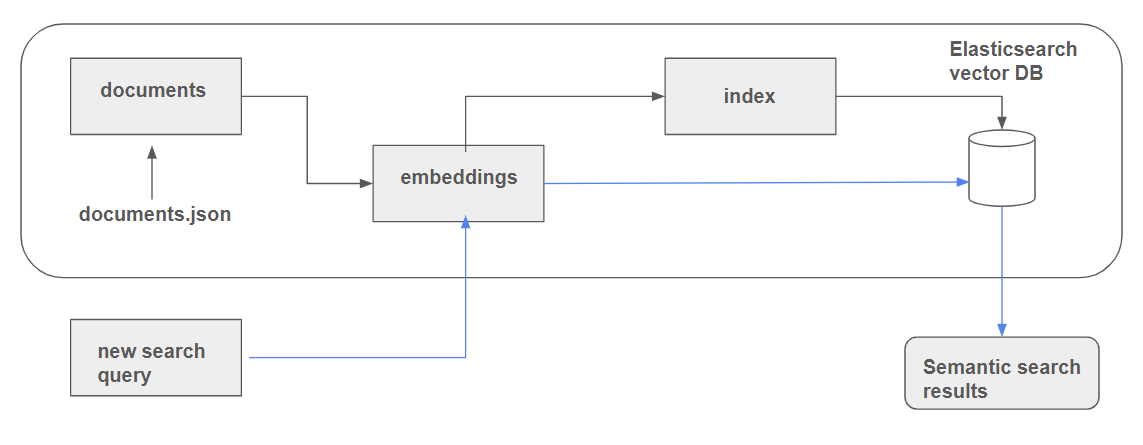

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

In [1]:
import platform
print(platform.python_version())

3.10.14


In [3]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

llmz


#### Step 1: Prepare documents

In [4]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [10]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-mpnet-base-v2")

In [11]:
len(model.encode("This is a simple sentence"))

768

In [12]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

In [13]:
#created the dense vector using the pre-trained model
operations = []
for doc in documents:
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

In [16]:
operations[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'text_vector': [-0.041030388325452805,
  0.02583417296409607,
  -0.03680189326405525,
  -0.020898321643471718,
  -0.020596249029040337,
  0.00935377273708582,
  -0.003331610234454274,
  -0.009491964243352413,
  0.030118007212877274,
  0.019082121551036835,
  0.012690044939517975,
  -0.017078766599297523,
  -0.0016324081225320697,
  0.1299726366996765,
  0.03096935711801052,
  -0.025823641568422318,
  0.02782307378947735,
  0.025159725919365883,
  -0.08081219345331192,
  -0.0036174170672893524,
  -0.008902022615075111,
  0.0034048568923026323,
  -0.023009344935417175,
  -0.03404531255364418,
  0.024598632007837296,
  0.01354563795030117,
  -0.025438936427235603,
  0.011951028369367123,
  -0.02054009400308132,
  -0.010077522136271,
  0.02057529240846634,
  0.

#### Step 3: Setup ElasticSearch connection 

In [14]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': 'b5b20eedc6c5', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'G1faiX-SShKlFQT45pNauA', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [17]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "text_vector":{"type":"dense_vector","dims": 768,"index":True,"similarity": "cosine"
        },
        }
    }
}

In [18]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

#### Step 5: Add documents into index

In [19]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Step 6: Create end user query

In [20]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [21]:
query = {
    "field" : "text_vector",
    "query_vector" :  vector_search_term,
    "k" : 5,
    "num_candidates" : 10000, 
}

In [26]:
res = es_client.search(index=index_name, knn=query, source=["text","section","question","course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'LOz2eJABw5T8bgvwe0Pi',
  '_score': 0.7147918,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': 'P-z2eJABw5T8bgvwnkYP',
  '_score': 0.61347353,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares a

#### Step 7: Perform Semantic Search & Advanced Search

In [27]:
response = es_client.search(
    index=index_name,
    query={
        "bool": {
            "must": {
             "multi_match": 
                        {"query": "windows or python?", 
                         "fields": ["text", "question","course","title"],
                         "type": "best_fields"
                        }
                    },
            "filter": {
                "term": {
                        "course": "data-engineering-zoomcamp"
                }
            }
        }
    }
)

In [28]:
response["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'cuz2eJABw5T8bgvwgEPJ',
  '_score': 7.728908,
  '_source': {'text': 'Problem: If you have already installed pgcli but bash doesn\'t recognize pgcli\nOn Git bash: bash: pgcli: command not found\nOn Windows Terminal: pgcli: The term \'pgcli\' is not recognized…\nSolution: Try adding a Python path C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\Scripts to Windows PATH\nFor details:\nGet the location: pip list -v\nCopy C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\site-packages\n3. Replace site-packages with Scripts: C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\Scripts\nIt can also be that you have Python installed elsewhere.\nFor me it was under c:\\python310\\lib\\site-packages\nSo I had to add c:\\python310\\lib\\Scripts to PATH, as shown below.\nPut the above path in "Path" (or "PATH") in System Variables\nReference: https://stackoverflow.com/a/68233660',
   'section': 'Module 1: Docker and Terraform',
   'question': 'PGCLI - pg

In [29]:
candidate_ids = [doc['_id'] for doc in res['hits']['hits']]

In [30]:
full_text_search_response = es_client.search(
    index=index_name,
    query={
        "bool": {
            "must": [
                {
                    "multi_match": {
                        "query": "windows or python?",
                        "fields": ["text", "question", "course", "title"],
                        "type": "best_fields"
                    }
                },
                {
                    "terms": {
                        "_id": candidate_ids  # Filter to only include candidates from vector search
                    }
                }
            ],
            "filter": {
                "term": {
                    "course": "data-engineering-zoomcamp"
                }
            }
        }
    }
)

In [31]:
full_text_search_response['hits']['hits']

[{'_index': 'course-questions',
  '_id': 'Hez2eJABw5T8bgvwe0My',
  '_score': 5.0649943,
  '_source': {'text': 'You can set it up on your laptop or PC if you prefer to work locally from your laptop or PC.\nYou might face some challenges, especially for Windows users. If you face cnd2\nIf you prefer to work on the local machine, you may start with the week 1 Introduction to Docker and follow through.\nHowever, if you prefer to set up a virtual machine, you may start with these first:\nUsing GitHub Codespaces\nSetting up the environment on a cloudV Mcodespace\nI decided to work on a virtual machine because I have different laptops & PCs for my home & office, so I can work on this boot camp virtually anywhere.',
   'section': 'General course-related questions',
   'question': 'Environment - Should I use my local machine, GCP, or GitHub Codespaces for my environment?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.04767603799700737,
    -0.012522546574473381,
    -0.008175

#### References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch